In [9]:
import pandas as pd
import useful_rdkit_utils as uru
import seaborn as sns
from sklearn.model_selection import RepeatedKFold, ShuffleSplit, KFold
from lightgbm import LGBMRegressor
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
from helper import scaffold_split

In [10]:
tqdm.pandas()

Read the data

In [11]:
df = pd.read_csv("biogen_logS.csv")

Calculate descriptors

In [12]:
descriptor_calc = uru.RDKitDescriptors()

In [13]:
df['desc'] = df.SMILES.progress_apply(descriptor_calc.calc_smiles)

  0%|          | 0/2173 [00:00<?, ?it/s]

In [14]:
X_vals = np.stack(df.desc)
y_vals = df.logS 

### Repeated K-Fold Cross-Validation

In [16]:
rkf = RepeatedKFold(n_splits=10, n_repeats=5, )
five_x_ten_list = []
for i, (train_index, test_index) in tqdm(enumerate(rkf.split(df)),total=rkf.get_n_splits()):
    train_X = X_vals[train_index]
    train_y = y_vals[train_index]
    test_X = X_vals[test_index]
    test_y = y_vals[test_index]
    rgr = LGBMRegressor()
    rgr.fit(train_X,train_y)
    pred = rgr.predict(test_X)
    r2 = r2_score(test_y, pred)
    mae = mean_absolute_error(test_y, pred)
    five_x_ten_list.append([r2, mae])

  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
five_x_ten_df = pd.DataFrame({"r2": [x[0] for x in five_x_ten_list],
                              "mae": [x[1] for x in five_x_ten_list],
                              "method": "5x10-fold"})

### Shuffle-Split - This is what train_test_split does

In [18]:
ss_list = []
ss = ShuffleSplit(n_splits=10)
for i, (train_index, test_index) in tqdm(enumerate(ss.split(df)),total=ss.get_n_splits()):
    train_X = X_vals[train_index]
    train_y = y_vals[train_index]
    test_X = X_vals[test_index]
    test_y = y_vals[test_index]
    rgr = LGBMRegressor()
    rgr.fit(train_X,train_y)
    pred = rgr.predict(test_X)
    r2 = r2_score(test_y, pred)
    mae = mean_absolute_error(test_y, pred)
    ss_list.append([r2, mae])

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
ss_df = pd.DataFrame({"r2": [x[0] for x in ss_list],
                              "mae": [x[1] for x in ss_list],
                              "method": "shuffle-split"})

### K-Fold Cross-Validation

In [33]:
kf_list = []
kf = KFold(n_splits=10, shuffle=True)
for i, (train_index, test_index) in tqdm(enumerate(kf.split(df)),total=kf.get_n_splits()):
    train_X = X_vals[train_index]
    train_y = y_vals[train_index]
    test_X = X_vals[test_index]
    test_y = y_vals[test_index]
    rgr = LGBMRegressor()
    rgr.fit(train_X,train_y)
    pred = rgr.predict(test_X)
    r2 = r2_score(test_y, pred)
    mae = mean_absolute_error(test_y, pred)
    kf_list.append([r2, mae])

  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
kf_df = pd.DataFrame({"r2": [x[0] for x in kf_list],
                              "mae": [x[1] for x in kf_list],
                              "method": "k-fold"})

In [35]:
kf_df

,r2,mae,method
0,0.391292,0.328437,k-fold
1,0.469199,0.417527,k-fold
2,0.305324,0.368381,k-fold
3,0.500359,0.352016,k-fold
4,0.466820,0.351838,k-fold
5,0.404517,0.360746,k-fold
6,0.385296,0.370319,k-fold
7,0.473323,0.356957,k-fold
8,0.331650,0.416784,k-fold
9,0.347953,0.394439,k-fold


In [36]:
scaf_list = []
for i in tqdm(range(0,10)):
    train_index, test_index = scaffold_split(df.SMILES, seed=i)
    train_X = X_vals[train_index]
    train_y = y_vals[train_index]
    test_X = X_vals[test_index]
    test_y = y_vals[test_index]
    rgr = LGBMRegressor()
    rgr.fit(train_X,train_y)
    pred = rgr.predict(test_X)
    r2 = r2_score(test_y, pred)
    mae = mean_absolute_error(test_y, pred)
    scaf_list.append([r2, mae])

  0%|          | 0/10 [00:00<?, ?it/s]

In [37]:
scaf_df = pd.DataFrame({"r2": [x[0] for x in scaf_list],
                              "mae": [x[1] for x in scaf_list],
                              "method": "scaffold-split"})

In [38]:
combo_df = pd.concat([five_x_ten_df, ss_df, kf_df, scaf_df])

Text(0, 0.5, '$R^2$')

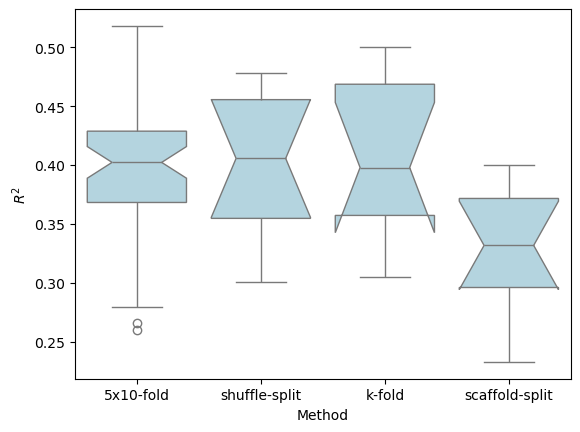

In [39]:
ax = sns.boxplot(x="method",y="r2",data=combo_df,color="lightblue",notch=True)
ax.set_xlabel("Method")
ax.set_ylabel("$R^2$")

Text(0, 0.5, 'MAE')

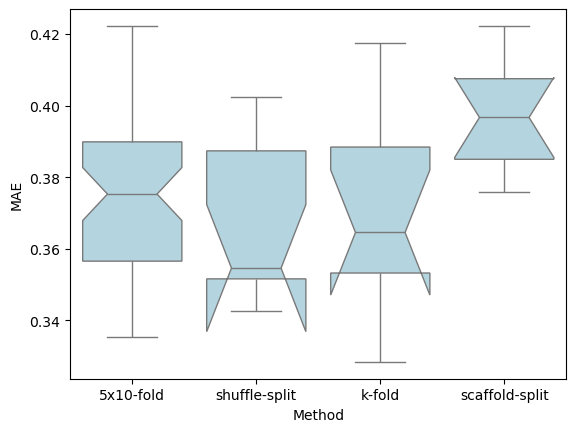

In [40]:
ax = sns.boxplot(x="method",y="mae",data=combo_df,color="lightblue",notch=True)
ax.set_xlabel("Method")
ax.set_ylabel("MAE")